# MayoB


| Dataset                                          | Best n | a₀ (Pa)   | b₀ (Pa·s) | λ₀ (s) = b₀⁄a₀ | Coefficients (aᵢ , λᵢ)                                                                                                                                                              | SSE          | MSE         |
| ------------------------------------------------ | ------ | --------- | --------- | -------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------ | ----------- |
| **All data – best fit**    | **6**  | 0.0000    | 2.1498    | 8517224637938.0391    | a₁ = 2041.1671, λ₁ = 268.6574<br>a₂ = 215.2892, λ₂ = 6.9091<br>a₃ = 271.3567, λ₃ = 1.1376<br>a₄ = 416.0326, λ₄ = 0.2525<br>a₅ = 469.8233, λ₅ = 0.0160<br>a₆ = 338.2059, λ₆ = 0.0672 | 341.4548 | 10.6705 |
| **All data – forced n = 3**                      | **3**      | 1914.7272 | 4.1993    | 0.0022         | a₁ = 566.7638, λ₁ = 0.4882<br>a₂ = 387.0931, λ₂ = 9.7079<br>a₃ = 647.0295, λ₃ = 0.0517                                                                                              | 15869.8487   | 495.9328    |
| **High-frequency subset** (ω > 1 rad s⁻¹, 9 pts) | **3**  | 2236.4782 | 2.6851    | 0.0012         | a₁ = 477.0247, λ₁ = 0.1422<br>a₂ = 520.9710, λ₂ = 0.0236<br>a₃ = 431.6869, λ₃ = 0.7534                                                                                              | 277.8018     | 15.4334     |
| **Low-frequency subset** (ω < 1 rad s⁻¹, 7 pts)  | **5**  | 0.0000    | 95.7627   | 13053642546271870     | a₁ = 1018.3409, λ₁ = 333.2672<br>a₂ = 984.5249, λ₂ = 333.8898<br>a₃ = 128.6654, λ₃ = 14.0793<br>a₄ = 337.5644, λ₄ = 0.8641<br>a₅ = 162.5265, λ₅ = 4.4521                            | 65.1249  | 4.6518  |


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import LogLocator, NullFormatter

In [ ]:
EXPERIMENTAL_DATA = {
    'MayoB': 
    }
}

In [ ]:
def gboth_model(omega_concat: np.ndarray, *params) -> np.ndarray:
    n_points = len(omega_concat) // 2
    omega_Gp = omega_concat[:n_points]
    omega_Gpp = omega_concat[n_points:]

    a0, b0 = params[:2]
    n = (len(params) - 2) // 2
    a_list = params[2 : 2 + n]
    lambda_list = params[2 + n : 2 + 2 * n]

    # Build G′
    Gp = a0 + np.sum(
        [
            ai * (omega_Gp**2 * li**2) / (1.0 + omega_Gp**2 * li**2)
            for ai, li in zip(a_list, lambda_list)
        ],
        axis=0,
    )

    # Build G″
    Gpp = b0 * omega_Gpp + np.sum(
        [
            ai * (omega_Gpp * li) / (1.0 + omega_Gpp**2 * li**2)
            for ai, li in zip(a_list, lambda_list)
        ],
        axis=0,
    )

    return np.concatenate([Gp, Gpp])


def fit_gboth_with_fixed_n(
    omega: np.ndarray,
    Gp: np.ndarray,
    Gpp: np.ndarray,
    n: int,
    p0_a0: float = 10.0,
    p0_b0: float = 1.0,
    p0_ai: float = 10.0,
    p0_lam: float = 1.0,
    maxfev: int = 10_000,
):
    y = np.concatenate([Gp, Gpp])
    omega_full = np.concatenate([omega, omega])

    p0 = [p0_a0, p0_b0] + [p0_ai] * n + [p0_lam] * n
    bounds = ([0.0] * (2 + 2 * n), [np.inf] * (2 + 2 * n))

    popt, _ = curve_fit(
        gboth_model,
        omega_full,
        y,
        p0=p0,
        bounds=bounds,
        maxfev=maxfev,
    )

    residuals = y - gboth_model(omega_full, *popt)
    SSE = np.sum(residuals**2)
    MSE = SSE / len(y)

    return popt, SSE, MSE


def find_best_n(
    omega: np.ndarray,
    Gp: np.ndarray,
    Gpp: np.ndarray,
    n_candidates: list[int] | tuple[int, ...],
):
    best = {"n": None, "params": None, "SSE": np.inf, "MSE": None}

    for n in n_candidates:
        popt, SSE, MSE = fit_gboth_with_fixed_n(omega, Gp, Gpp, n)
        if SSE < best["SSE"]:
            best.update({"n": n, "params": popt, "SSE": SSE, "MSE": MSE})

    return best


def subset_data(
    d: dict[str, np.ndarray],
    indices: slice | list[int] | np.ndarray | None = None,
):
    if indices is None:
        return d  # No sub‑selection requested.

    # Build a *new* dict so original data remain untouched.
    return {
        "omega": d["omega"][indices],
        "G_prime_exp": d["G_prime_exp"][indices],
        "G_double_prime_exp": d["G_double_prime_exp"][indices],
    }


def evaluate_model(omega, params):
    n = (len(params) - 2) // 2
    a0, b0 = params[:2]
    a_list = params[2 : 2 + n]
    lambda_list = params[2 + n : 2 + 2 * n]
    

    Gp = a0 + np.sum(
        [
            ai * (omega**2 * li**2) / (1.0 + omega**2 * li**2)
            for ai, li in zip(a_list, lambda_list)
        ],
        axis=0,
    )

    Gpp = b0 * omega + np.sum(
        [
            ai * (omega * li) / (1.0 + omega**2 * li**2)
            for ai, li in zip(a_list, lambda_list)
        ],
        axis=0,
    )
    
    return Gp, Gpp

def _plot_single_dataset(
    name: str,
    data: dict[str, np.ndarray],
    result: dict,
    ax: plt.Axes,
):
    omega_line = np.logspace(
        np.log10(data["omega"].min() * 0.8),
        np.log10(data["omega"].max() * 1.2),
        400,
    )

    G_prime_line, G_double_prime_line = evaluate_model(omega_line, result["params"])

    ax.loglog(data["omega"], data["G_prime_exp"], "o", label=f"{name} G′ data")
    ax.loglog(omega_line, G_prime_line, "-", label=f"{name} G′ fit (n={result['n']})")

    ax.loglog(data["omega"], data["G_double_prime_exp"], "x", label=f"{name} G″ data")
    ax.loglog(omega_line, G_double_prime_line, "--", label=f"{name} G″ fit (n={result['n']})")

    ax.set_xlabel(r"$\omega$ (rad/s)")
    ax.set_ylabel("Modulus (Pa)")
    ax.grid(True, which="both", ls="--", alpha=0.4)



def analyze(
    plan: dict[str, dict],
    *,
    show_plot: bool = True,
):
    results: dict[str, dict] = {}
    for name, cfg in plan.items():
        if name not in EXPERIMENTAL_DATA:
            raise KeyError(f"Dataset {name!r} not found in EXPERIMENTAL_DATA")
        
        data = subset_data(EXPERIMENTAL_DATA[name], cfg.get("indices"))
        n_candidate_list = cfg.get("n_candidates", (1, 2, 3))
        
        res = find_best_n(
            data["omega"],
            data["G_prime_exp"],
            data["G_double_prime_exp"],
            n_candidate_list,
        )
        results[name] = res
        
        p = res["params"]
        n = res["n"]
        a0, b0 = p[:2]
        a_list = p[2 : 2 + n]
        lam_list = p[2 + n : 2 + 2 * n]
        
        print(f"\n{name}: n = {n}, SSE = {res['SSE']:.4f}, MSE = {res['MSE']:.4f}")
        print(f"  a0 = {a0:.4f}, b0 = {b0:.4f}  (b0/a0 = {b0 / a0 if a0 else np.inf:.4f})")
        for i, (ai, li) in enumerate(zip(a_list, lam_list), 1):
            print(f"  a{i} = {ai:.4f}, λ{i} = {li:.4f}")
    
    if show_plot and results:
        # Increase figure height to accommodate vertical labels
        fig, ax = plt.subplots(figsize=(12, 9))  
        
        # Collect all data points for setting axis limits
        all_omega = []
        all_g_prime = []
        all_g_double_prime = []
        
        for name, cfg in plan.items():
            data = subset_data(EXPERIMENTAL_DATA[name], cfg.get("indices"))
            _plot_single_dataset(name, data, results[name], ax=ax)
            
            # Collect data for axis scaling
            all_omega.extend(data["omega"])
            all_g_prime.extend(data["G_prime_exp"])
            all_g_double_prime.extend(data["G_double_prime_exp"])
        
        # Set more detailed x-axis (omega)
        x_min, x_max = min(all_omega), max(all_omega)
        x_ticks = np.linspace(x_min, x_max, 10)  # 10 tick marks
        ax.set_xticks(x_ticks)
        
        # Rotate x-axis labels vertically and align them
        ax.set_xticklabels([f'{x:.2f}' for x in x_ticks], 
                            rotation=90,   # Rotate 90 degrees
                            ha='center',   # Horizontal alignment
                            va='top')      # Vertical alignment
        ax.set_xlabel('Omega (ω)', labelpad=20)  # Add some padding to the label
        
        # Set more detailed y-axis (G prime and G double prime)
        y_min = min(min(all_g_prime), min(all_g_double_prime))
        y_max = max(max(all_g_prime), max(all_g_double_prime))
        y_ticks = np.linspace(y_min, y_max, 10)  # 10 tick marks
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([f'{y:.2f}' for y in y_ticks])
        ax.set_ylabel('G\' and G"')
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        
        ax.legend()
        
        # Adjust layout to prevent cutting off labels
        plt.tight_layout()
        plt.show()
    
    return results





## All data – best fit 


MayoB: n = 6, SSE = 341.4548, MSE = 10.6705
  a0 = 0.0000, b0 = 2.1498  (b0/a0 = 8517224637938.0391)
  a1 = 2041.1671, λ1 = 268.6574
  a2 = 215.2892, λ2 = 6.9091
  a3 = 271.3567, λ3 = 1.1376
  a4 = 416.0326, λ4 = 0.2525
  a5 = 469.8233, λ5 = 0.0160
  a6 = 338.2059, λ6 = 0.0672


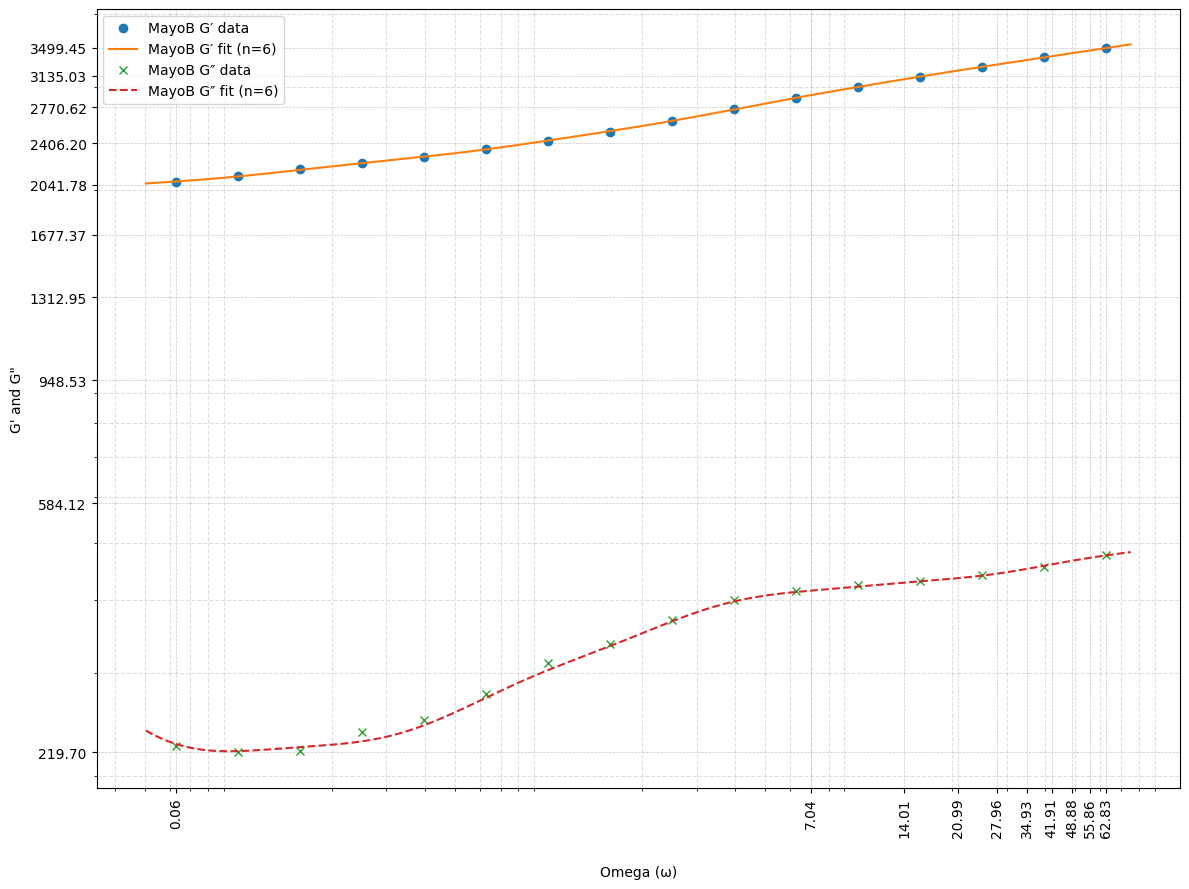

In [22]:
if __name__ == "__main__":

    analysis_plan = {
        "MayoB": {
            "indices": None,
            "n_candidates": [1, 2, 3, 4, 5, 6],
        },

    }

    analyze(analysis_plan, show_plot=True)

## All data – with only three maxwell models


MayoB: n = 3, SSE = 15869.8487, MSE = 495.9328
  a0 = 1914.7272, b0 = 4.1993  (b0/a0 = 0.0022)
  a1 = 566.7638, λ1 = 0.4882
  a2 = 387.0931, λ2 = 9.7079
  a3 = 647.0295, λ3 = 0.0517


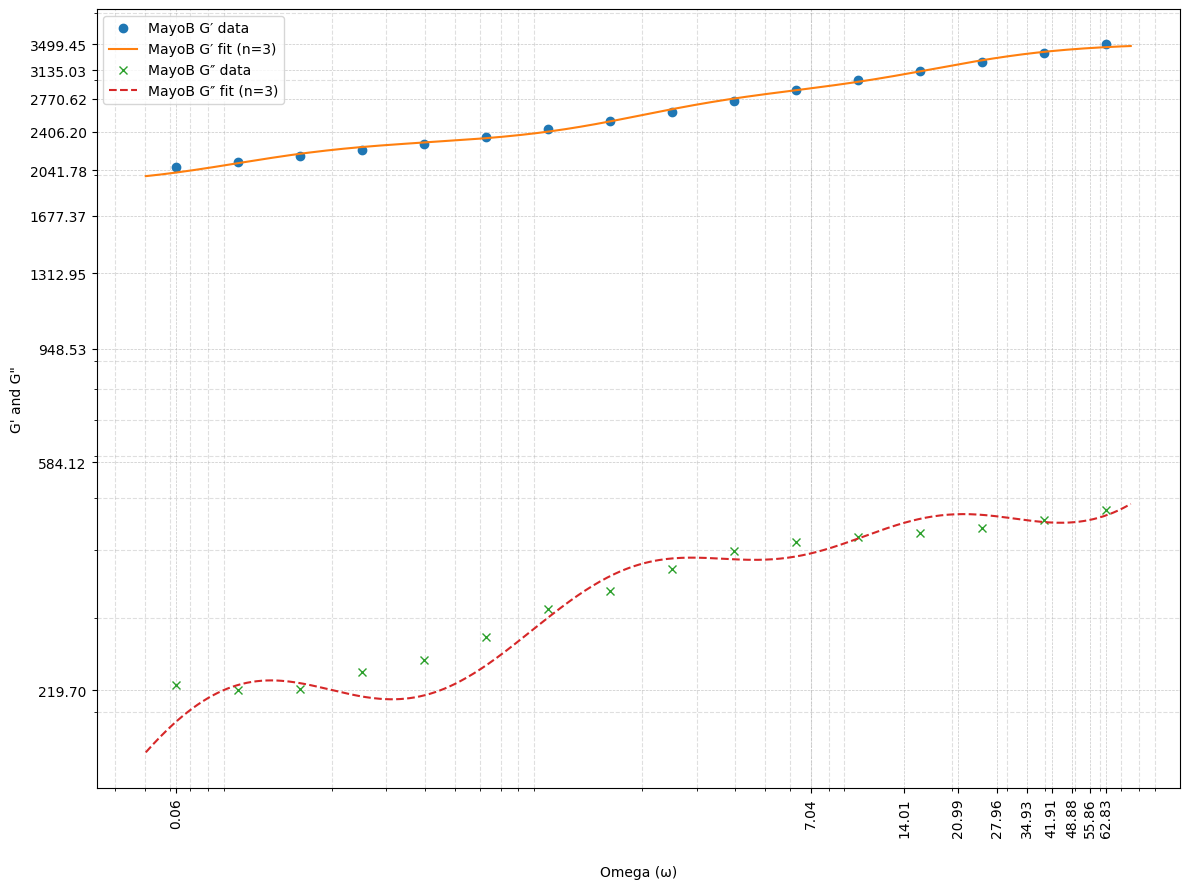

In [23]:
# ---------------------------------------------------------------------------
if __name__ == "__main__":

    analysis_plan = {
        "MayoB": {
            "indices": None,
            "n_candidates": [1, 2, 3],
        },

    }

    analyze(analysis_plan, show_plot=True)

## High-frequency subset (ω > 1 rad s⁻¹) - best fit


MayoB: n = 3, SSE = 277.8018, MSE = 15.4334
  a0 = 2236.4782, b0 = 2.6851  (b0/a0 = 0.0012)
  a1 = 477.0247, λ1 = 0.1422
  a2 = 520.9710, λ2 = 0.0236
  a3 = 431.6869, λ3 = 0.7534


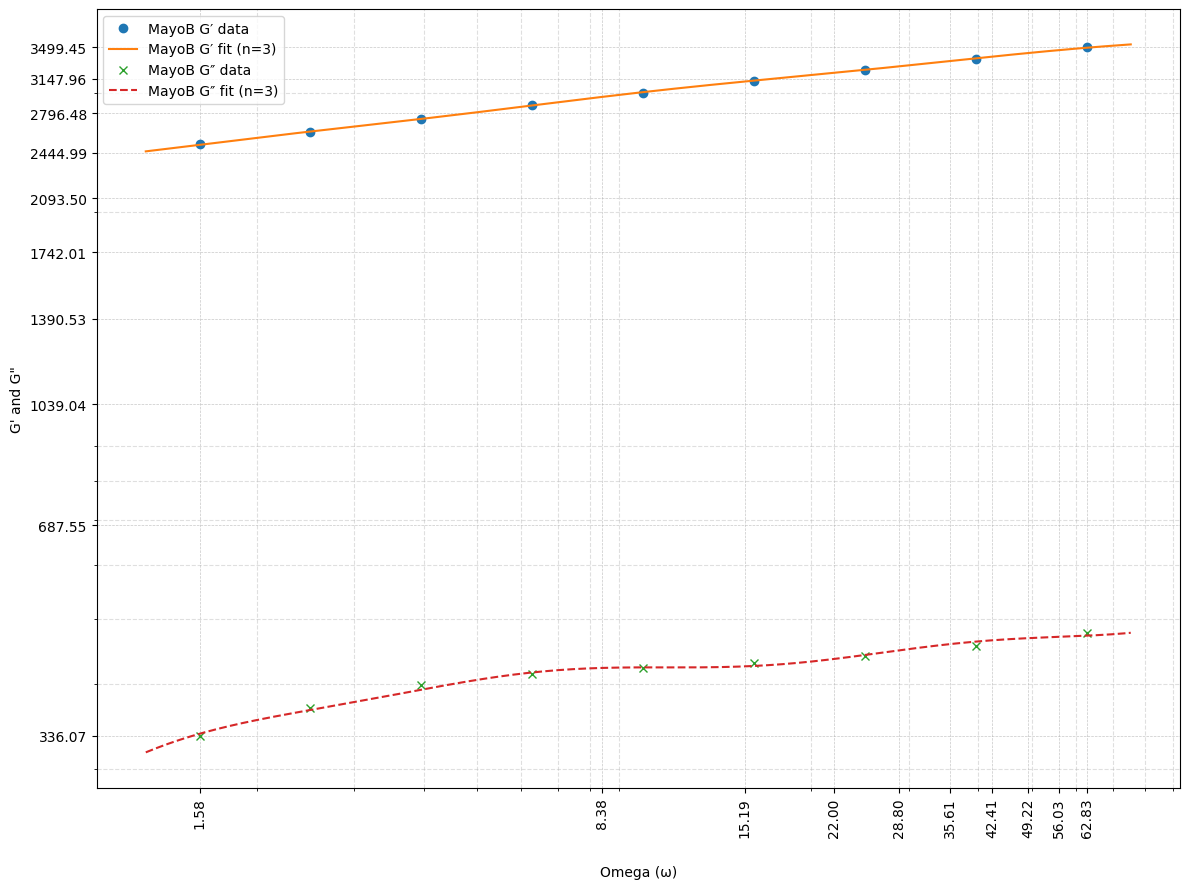

In [25]:
if __name__ == "__main__":

    analysis_plan = {
        "MayoB": {
            "indices": slice(0,9),
            "n_candidates": [1, 2, 3],
        },
    
    }

    analyze(analysis_plan, show_plot=True)

## Low-frequency subset (ω < 1 rad s⁻¹) - best fit


MayoB: n = 5, SSE = 65.1249, MSE = 4.6518
  a0 = 0.0000, b0 = 95.7627  (b0/a0 = 13053642546271870.0000)
  a1 = 1018.3409, λ1 = 333.2672
  a2 = 984.5249, λ2 = 333.8898
  a3 = 128.6654, λ3 = 14.0793
  a4 = 337.5644, λ4 = 0.8641
  a5 = 162.5265, λ5 = 4.4521


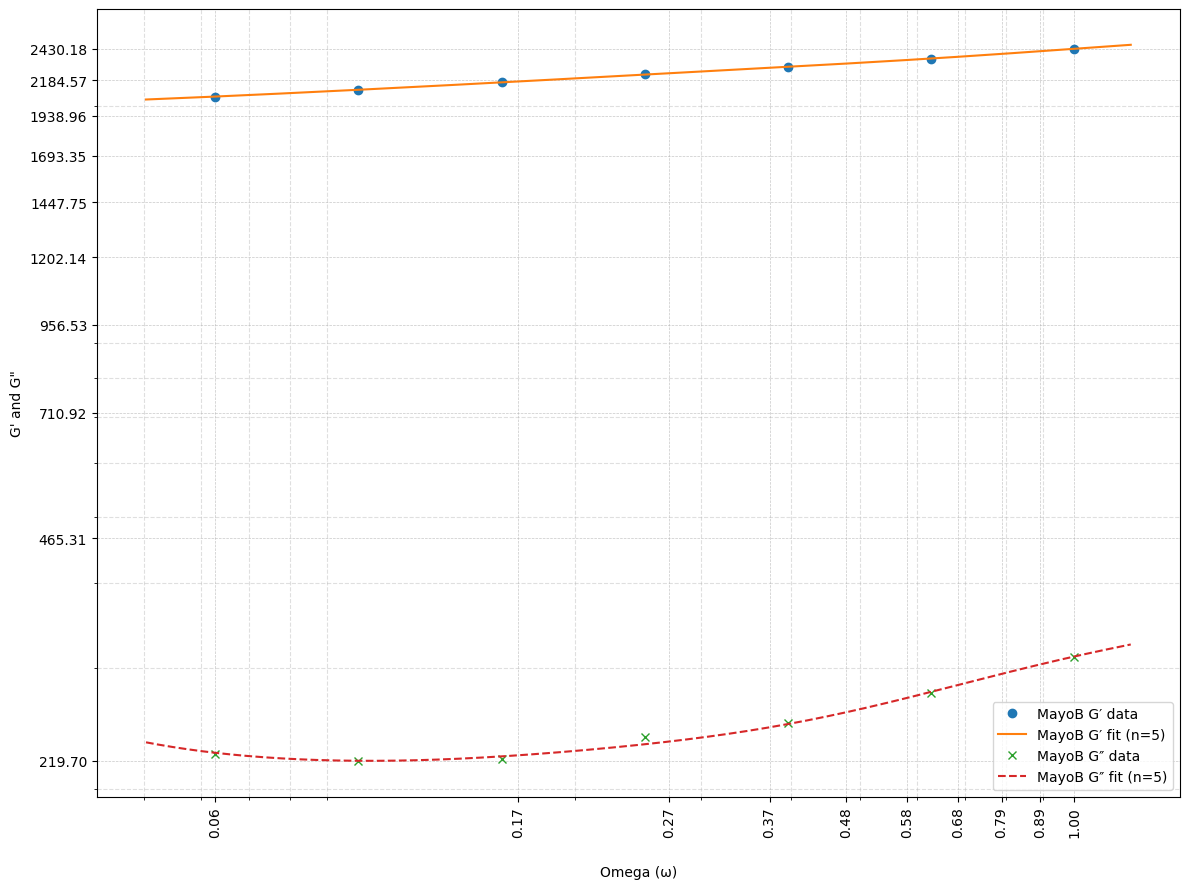

In [26]:
if __name__ == "__main__":

    analysis_plan = {
        "MayoB": {
            "indices": slice(-7, None),
            "n_candidates": [1, 2, 3, 4, 5],
        },
    
    }

    analyze(analysis_plan, show_plot=True)